In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Architecture idea (SIMPLE DIAGRAM)

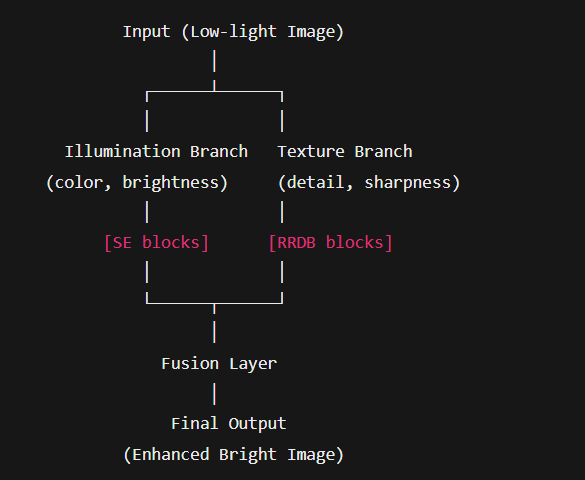

In [4]:
import os
import random
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import PeakSignalNoiseRatio as PSNR, StructuralSimilarityIndexMeasure as SSIM
from piq import LPIPS
import os
import torch.nn.functional as F
from torchvision.models import vgg19
from torchvision.utils import save_image
from datetime import datetime


In [3]:
# !pip install torchmetrics piq

Paths to datasets


In [ ]:
dataset_path = '/home/kkharel2/DL_Proj/SDSC_4008_PSA blocks added/lol_dataset'
raw_train_path = f'{dataset_path}/our485'
test_path = f'{dataset_path}/eval15'

In [ ]:
class LOLDataset(Dataset):
    def __init__(self, root_dir, input_transform=None, target_transform=None):
        self.root_dir = root_dir
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.low_dir = os.path.join(root_dir, "low")
        self.high_dir = os.path.join(root_dir, "high")
        self.image_names = sorted(os.listdir(self.low_dir))

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        low_img_path = os.path.join(self.low_dir, self.image_names[idx])
        high_img_path = os.path.join(self.high_dir, self.image_names[idx])

        low_img = Image.open(low_img_path).convert("RGB")
        high_img = Image.open(high_img_path).convert("RGB")

        if self.input_transform:
            low_img = self.input_transform(low_img)

        if self.target_transform:
            high_img = self.target_transform(high_img)

        return low_img, high_img

In [ ]:
# Transform Pipelines

train_input_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [ ]:
# Dataset Preparation
raw_dataset = LOLDataset(
    root_dir=raw_train_path,
    input_transform=None,
    target_transform=None
)

train_size = int(0.8 * len(raw_dataset))
train_dataset, val_dataset = random_split(raw_dataset, [train_size, len(raw_dataset)-train_size])

# Assign transforms
train_dataset.dataset.input_transform = train_input_transform
train_dataset.dataset.target_transform = target_transform
val_dataset.dataset.input_transform = target_transform
val_dataset.dataset.target_transform = target_transform

test_dataset = LOLDataset(
    root_dir=test_path,
    input_transform=target_transform,
    target_transform=target_transform
)

### DataLoaders


In [ ]:
from torch.utils.data import DataLoader

batch_size = 8

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True   # Speeds up transfer to GPU
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,         # No need for validation
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,       # Often use batch_size=1 for testing
    shuffle=False,
    num_workers=1
)

In [ ]:
def show_true_images(low_batch, high_batch, n=4):

    """
    Shows EXACTLY what's in your dataset with correct color handling.
    Works for both normalized and unnormalized images.
    """

    plt.figure(figsize=(18, 8))

    for i in range(min(n, len(low_batch))):
        # --- Low-light ---
        plt.subplot(2, n, i+1)
        low_img = low_batch[i].permute(1, 2, 0).numpy()

        # Handle normalization if present
        if low_img.min() < 0:  # Likely normalized
            low_img = (low_img * 0.5 + 0.5)  # Reverse imagenet norm

        # Ensure proper image range
        low_img = np.clip(low_img, 0, 1)
        plt.imshow(low_img)
        plt.title(f"Low")
        plt.axis('off')

        # --- Normal-light ---
        plt.subplot(2, n, n+i+1)
        high_img = high_batch[i].permute(1, 2, 0).numpy()

        if high_img.min() < 0:  # Likely normalized
            high_img = (high_img * 0.5 + 0.5)

        high_img = np.clip(high_img, 0, 1)
        plt.imshow(high_img)
        plt.title(f"High")
        plt.axis('off')

    plt.tight_layout()
    plt.show()



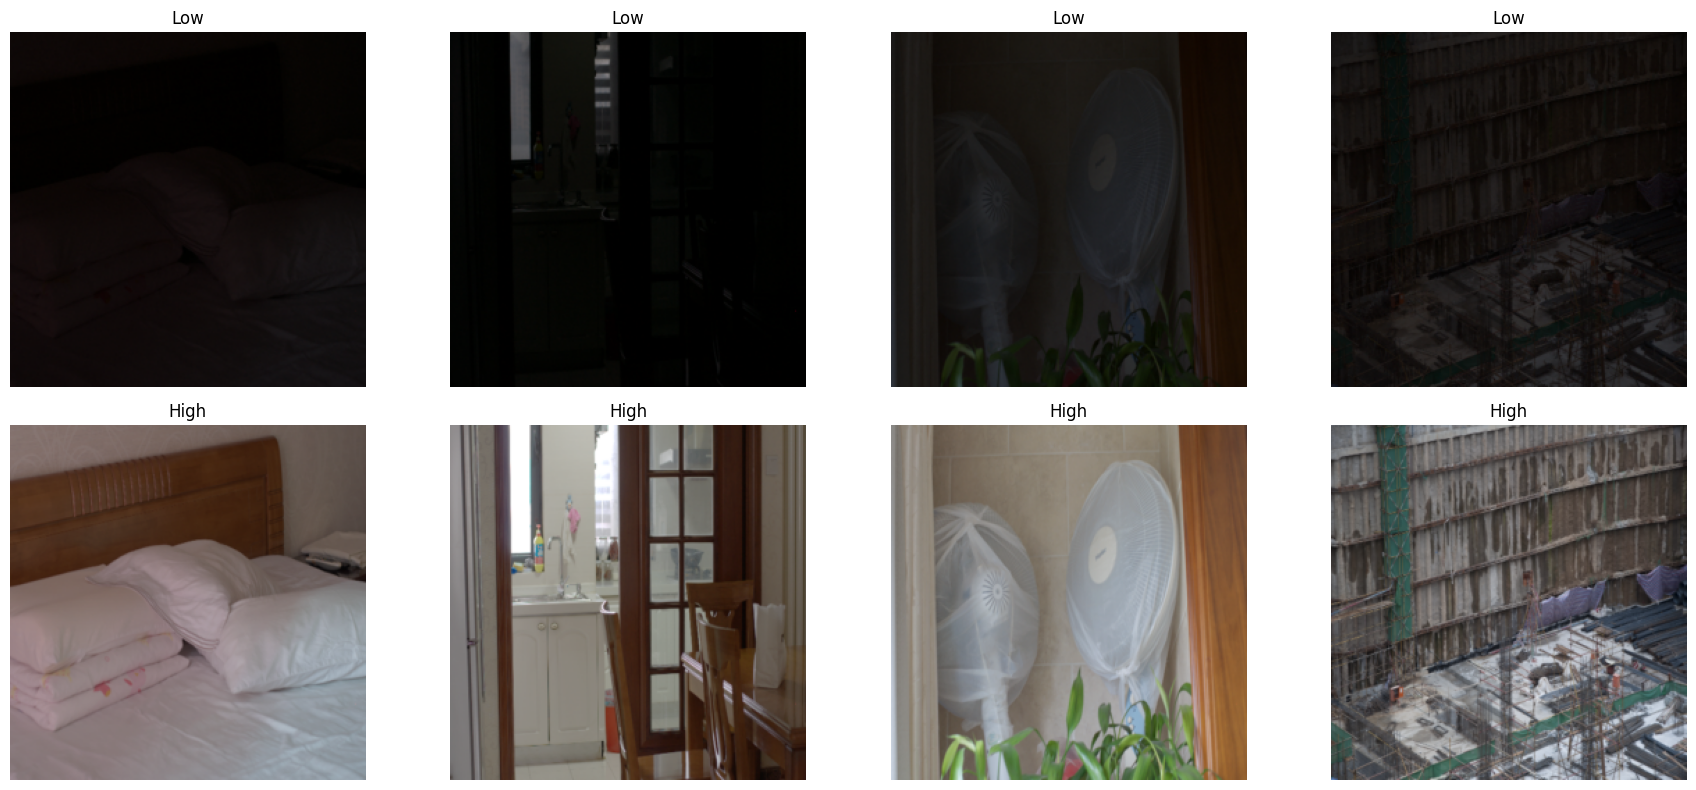

In [ ]:
# Usage
low, high = next(iter(train_loader))
show_true_images(low, high)

## MODEL ARCHITECTURE

In [5]:
#SE Blocks:

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block for channel attention"""

    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


# Residual-in-Residual Dense Block (RRDB)

class RRDB(nn.Module):
    """Residual-in-Residual Dense Block"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels*2, channels, 3, padding=1)
        self.conv3 = nn.Conv2d(channels*3, channels, 3, padding=1)
        self.lrelu = nn.LeakyReLU(0.2)
        self.se = SEBlock(channels)

    def forward(self, x):
        out1 = self.lrelu(self.conv1(x))
        out2 = self.lrelu(self.conv2(torch.cat([x, out1], 1)))
        out3 = self.conv3(torch.cat([x, out1, out2], 1))
        return self.se(out3 * 0.2 + x)  # Residual scaling


Generator


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # Illumination Branch (color/brightness)
        self.illum_conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.illum_rrdb = nn.Sequential(*[RRDB(32) for _ in range(4)])
        self.illum_conv2 = nn.Conv2d(32, 3, 3, padding=1)

        # Texture Branch (detail/sharpness)
        self.texture_conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.texture_rrdb = nn.Sequential(*[RRDB(64) for _ in range(6)])
        self.texture_conv2 = nn.Conv2d(64, 3, 3, padding=1)

        # Fusion
        self.fusion = nn.Sequential(
            nn.Conv2d(6, 32, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Tanh()  # Output in [-1,1] -> remap to [0,1] later
        )

    def forward(self, x):
        # Illumination path
        illum = self.illum_conv1(x)
        illum = self.illum_rrdb(illum)
        illum = torch.sigmoid(self.illum_conv2(illum))  # [0,1]

        # Texture path
        texture = self.texture_conv1(x)
        texture = self.texture_rrdb(texture)
        texture = self.texture_conv2(texture)  # No activation (keep details)

        # Fusion
        fused = self.fusion(torch.cat([illum, texture], 1))
        return (fused + 1) / 2  # Map to [0,1]

Discriminator

In [7]:
class Discriminator(nn.Module):
    """PatchGAN discriminator"""
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # Input: 3 x 256 x 256
            nn.Conv2d(3, 64, 4, stride=2, padding=1),  # 128
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 64
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),  # 32
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=1, padding=1),  # 31
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)  # 30x30 patch output
        )

    def forward(self, x):
        return self.model(x)

Loss Functions


In [8]:
class GANLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()

    def forward(self, pred, target_is_real):
        target = torch.ones_like(pred) if target_is_real else torch.zeros_like(pred)
        return self.loss(pred, target)


class PerceptualLoss(nn.Module):

    """VGG-based perceptual loss"""

    def __init__(self):
        super().__init__()
        vgg = vgg19(pretrained=True).features[:16]
        self.vgg = nn.Sequential(*[m for m in vgg if not isinstance(m, nn.MaxPool2d)])
        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input = F.interpolate(input, size=(224,224)) if input.shape[-1] != 224 else input
        vgg_target = F.interpolate(target, size=(224,224)) if target.shape[-1] != 224 else target
        return F.l1_loss(self.vgg(vgg_input), self.vgg(vgg_target))

## Training preparation:

In [9]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

# Hyperparameters
config = {
    'batch_size': 8,
    'epochs': 200,
    'lr_g': 2e-4,
    'lr_d': 1e-4,
    'betas': (0.5, 0.999),
    'lambda_l1': 100,
    'lambda_perceptual': 0.1,
    'save_interval': 1,  # Save every epoch
    'sample_interval': 100,  # Generate samples every N batches
}

# Initialize models and losses
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Losses
criterion_gan = GANLoss()
criterion_l1 = nn.L1Loss()
criterion_perceptual = PerceptualLoss().to(device)

# Optimizers with LR scheduling
opt_g = torch.optim.Adam(generator.parameters(), lr=config['lr_g'], betas=config['betas'])
opt_d = torch.optim.Adam(discriminator.parameters(), lr=config['lr_d'], betas=config['betas'])
scheduler_g = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_g, 'min', patience=5, factor=0.5)
scheduler_d = torch.optim.lr_scheduler.ReduceLROnPlateau(opt_d, 'min', patience=5, factor=0.5)

# Initialize metrics
psnr = PSNR().to(device)
ssim = SSIM().to(device)
lpips = LPIPS(replace_pooling=True).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 152MB/s]
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignal

## Training LOOP

In [ ]:
def validate(generator, val_loader, epoch):
    """Evaluate model on validation set"""
    generator.eval()
    val_metrics = {'psnr': 0, 'ssim': 0, 'lpips': 0}

    with torch.no_grad():
        for low, high in tqdm(val_loader, desc=f'Validation Epoch {epoch}', leave=False):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            val_metrics['psnr'] += psnr(fake, high)
            val_metrics['ssim'] += ssim(fake, high)
            val_metrics['lpips'] += lpips(fake, high)

    # Average across batches
    for k in val_metrics:
        val_metrics[k] /= len(val_loader)

    return val_metrics

In [ ]:

def train_gan(
    generator,
    discriminator,
    train_loader,
    val_loader,
    criterion_gan,
    criterion_l1,
    criterion_perceptual,
    opt_g,
    opt_d,
    epochs,
    device,
    save_dir="RRDB_SE_CHECKPOINTS"
):
    os.makedirs(save_dir, exist_ok=True)
    best_ssim = 0

    for epoch in range(epochs):
        # Training phase
        generator.train()
        discriminator.train()

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for low, high in train_bar:
            low, high = low.to(device), high.to(device)

            # --- Discriminator Update ---
            opt_d.zero_grad()

            # Real images
            real_pred = discriminator(high)
            real_loss = criterion_gan(real_pred, True)

            # Fake images
            fake = generator(low).detach()
            fake_pred = discriminator(fake)
            fake_loss = criterion_gan(fake_pred, False)

            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            opt_d.step()

            # --- Generator Update ---
            opt_g.zero_grad()
            fake = generator(low)
            g_gan_loss = criterion_gan(discriminator(fake), True)
            g_l1_loss = criterion_l1(fake, high) * 100
            g_perc_loss = criterion_perceptual(fake, high) * 0.1
            g_loss = g_gan_loss + g_l1_loss + g_perc_loss
            g_loss.backward()
            opt_g.step()

            # Update progress bar
            train_bar.set_postfix({
                'D_loss': f'{d_loss.item():.3f}',
                'G_loss': f'{g_loss.item():.3f}',
                'L1': f'{g_l1_loss.item():.3f}'
            })

        # Validation phase
        val_metrics = validate(generator, val_loader, epoch+1)

        # Print metrics
        print(f"\nValidation @ Epoch {epoch+1}:")
        print(f"PSNR: {val_metrics['psnr']:.2f} dB | SSIM: {val_metrics['ssim']:.4f} | LPIPS: {val_metrics['lpips']:.4f}")

        # Save checkpoint
        torch.save({
            'epoch': epoch+1,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'opt_g': opt_g.state_dict(),
            'opt_d': opt_d.state_dict(),
            'metrics': val_metrics
        }, os.path.join(save_dir, f'epoch_{epoch+1}.pth'))

        # Save best model
        if val_metrics['ssim'] > best_ssim:
            best_ssim = val_metrics['ssim']
            torch.save(generator.state_dict(), os.path.join(save_dir, 'best_model.pth'))
            print(f"🔥 New best model (SSIM: {best_ssim:.4f}) saved!")

        # Sample images
        if (epoch+1) % 5 == 0:
            with torch.no_grad():
                fake = generator(low[:3])  # First 3 samples
                save_image(
                    torch.cat([low[:3], fake, high[:3]], 0),
                    os.path.join(save_dir, f'sample_epoch_{epoch+1}.png'),
                    nrow=3,
                    normalize=True
                )


In [ ]:
# Usage
train_gan(
    generator=generator,
    discriminator=discriminator,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion_gan=criterion_gan,
    criterion_l1=criterion_l1,
    criterion_perceptual=criterion_perceptual,
    opt_g=opt_g,
    opt_d=opt_d,
    epochs=200,
    device=device
)

Epoch 1/200: 100%|██████████| 49/49 [00:23<00:00,  2.13it/s, D_loss=0.533, G_loss=15.478, L1=14.236]



Validation @ Epoch 1:
PSNR: 13.83 dB | SSIM: 0.6170 | LPIPS: 0.4848
🔥 New best model (SSIM: 0.6170) saved!


Epoch 2/200: 100%|██████████| 49/49 [00:23<00:00,  2.13it/s, D_loss=0.210, G_loss=12.364, L1=10.612]



Validation @ Epoch 2:
PSNR: 16.59 dB | SSIM: 0.6455 | LPIPS: 0.4897
🔥 New best model (SSIM: 0.6455) saved!


Epoch 3/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.252, G_loss=15.268, L1=12.367]



Validation @ Epoch 3:
PSNR: 17.24 dB | SSIM: 0.6530 | LPIPS: 0.4685
🔥 New best model (SSIM: 0.6530) saved!


Epoch 4/200: 100%|██████████| 49/49 [00:23<00:00,  2.09it/s, D_loss=0.708, G_loss=11.739, L1=9.705] 



Validation @ Epoch 4:
PSNR: 16.57 dB | SSIM: 0.6948 | LPIPS: 0.4221
🔥 New best model (SSIM: 0.6948) saved!


Epoch 5/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.088, G_loss=16.811, L1=13.479]



Validation @ Epoch 5:
PSNR: 16.54 dB | SSIM: 0.7001 | LPIPS: 0.4244
🔥 New best model (SSIM: 0.7001) saved!


Epoch 6/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.337, G_loss=10.153, L1=9.729] 



Validation @ Epoch 6:
PSNR: 17.08 dB | SSIM: 0.7342 | LPIPS: 0.3802
🔥 New best model (SSIM: 0.7342) saved!


Epoch 7/200: 100%|██████████| 49/49 [00:23<00:00,  2.08it/s, D_loss=0.511, G_loss=12.295, L1=9.991] 



Validation @ Epoch 7:
PSNR: 18.06 dB | SSIM: 0.7342 | LPIPS: 0.3841


Epoch 8/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.425, G_loss=14.635, L1=13.187]



Validation @ Epoch 8:
PSNR: 17.24 dB | SSIM: 0.7568 | LPIPS: 0.3921
🔥 New best model (SSIM: 0.7568) saved!


Epoch 9/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.305, G_loss=15.084, L1=12.381]



Validation @ Epoch 9:
PSNR: 17.93 dB | SSIM: 0.7595 | LPIPS: 0.3645
🔥 New best model (SSIM: 0.7595) saved!


Epoch 10/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.280, G_loss=12.027, L1=9.543] 



Validation @ Epoch 10:
PSNR: 17.82 dB | SSIM: 0.7770 | LPIPS: 0.3464
🔥 New best model (SSIM: 0.7770) saved!


Epoch 11/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.262, G_loss=12.497, L1=10.584]



Validation @ Epoch 11:
PSNR: 17.43 dB | SSIM: 0.6923 | LPIPS: 0.4292


Epoch 12/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.103, G_loss=15.668, L1=12.648]



Validation @ Epoch 12:
PSNR: 18.02 dB | SSIM: 0.7336 | LPIPS: 0.3850


Epoch 13/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.329, G_loss=11.287, L1=8.886] 



Validation @ Epoch 13:
PSNR: 18.40 dB | SSIM: 0.7533 | LPIPS: 0.3832


Epoch 14/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.711, G_loss=16.419, L1=14.729]



Validation @ Epoch 14:
PSNR: 16.38 dB | SSIM: 0.7109 | LPIPS: 0.3821


Epoch 15/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.278, G_loss=12.373, L1=9.895] 



Validation @ Epoch 15:
PSNR: 17.79 dB | SSIM: 0.7167 | LPIPS: 0.4386


Epoch 16/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.699, G_loss=11.154, L1=10.028]



Validation @ Epoch 16:
PSNR: 18.29 dB | SSIM: 0.7246 | LPIPS: 0.4039


Epoch 17/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.227, G_loss=14.332, L1=11.159]



Validation @ Epoch 17:
PSNR: 18.32 dB | SSIM: 0.7468 | LPIPS: 0.3694


Epoch 18/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.239, G_loss=14.135, L1=11.235]



Validation @ Epoch 18:
PSNR: 17.90 dB | SSIM: 0.7309 | LPIPS: 0.3915


Epoch 19/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.343, G_loss=14.614, L1=12.717]



Validation @ Epoch 19:
PSNR: 18.43 dB | SSIM: 0.7638 | LPIPS: 0.3671


Epoch 20/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.252, G_loss=9.858, L1=7.206]  



Validation @ Epoch 20:
PSNR: 16.48 dB | SSIM: 0.7684 | LPIPS: 0.3433


Epoch 21/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.450, G_loss=13.860, L1=10.569]



Validation @ Epoch 21:
PSNR: 17.50 dB | SSIM: 0.7455 | LPIPS: 0.3584


Epoch 22/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.470, G_loss=13.290, L1=11.156]



Validation @ Epoch 22:
PSNR: 18.54 dB | SSIM: 0.7868 | LPIPS: 0.3339
🔥 New best model (SSIM: 0.7868) saved!


Epoch 23/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.531, G_loss=9.806, L1=8.488]  



Validation @ Epoch 23:
PSNR: 19.20 dB | SSIM: 0.7954 | LPIPS: 0.3019
🔥 New best model (SSIM: 0.7954) saved!


Epoch 24/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.218, G_loss=12.924, L1=10.567]



Validation @ Epoch 24:
PSNR: 19.10 dB | SSIM: 0.8138 | LPIPS: 0.2866
🔥 New best model (SSIM: 0.8138) saved!


Epoch 25/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.445, G_loss=12.134, L1=9.014] 



Validation @ Epoch 25:
PSNR: 19.13 dB | SSIM: 0.8140 | LPIPS: 0.2862
🔥 New best model (SSIM: 0.8140) saved!


Epoch 26/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.202, G_loss=15.952, L1=13.072]



Validation @ Epoch 26:
PSNR: 18.46 dB | SSIM: 0.7623 | LPIPS: 0.3664


Epoch 27/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.350, G_loss=10.747, L1=8.398] 



Validation @ Epoch 27:
PSNR: 19.32 dB | SSIM: 0.7925 | LPIPS: 0.3046


Epoch 28/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.240, G_loss=10.298, L1=8.235] 



Validation @ Epoch 28:
PSNR: 18.63 dB | SSIM: 0.7833 | LPIPS: 0.3138


Epoch 29/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.295, G_loss=10.263, L1=8.027] 



Validation @ Epoch 29:
PSNR: 18.38 dB | SSIM: 0.7958 | LPIPS: 0.2988


Epoch 30/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.242, G_loss=13.017, L1=10.933]



Validation @ Epoch 30:
PSNR: 17.81 dB | SSIM: 0.7462 | LPIPS: 0.3095


Epoch 31/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.605, G_loss=7.568, L1=6.701]  



Validation @ Epoch 31:
PSNR: 18.84 dB | SSIM: 0.7999 | LPIPS: 0.3132


Epoch 32/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.159, G_loss=10.479, L1=7.839] 



Validation @ Epoch 32:
PSNR: 18.88 dB | SSIM: 0.7904 | LPIPS: 0.3110


Epoch 33/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.256, G_loss=12.004, L1=8.851] 



Validation @ Epoch 33:
PSNR: 19.28 dB | SSIM: 0.7829 | LPIPS: 0.3251


Epoch 34/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.322, G_loss=6.182, L1=5.114]  



Validation @ Epoch 34:
PSNR: 19.41 dB | SSIM: 0.7918 | LPIPS: 0.2887


Epoch 35/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.235, G_loss=15.694, L1=11.792]



Validation @ Epoch 35:
PSNR: 19.49 dB | SSIM: 0.8041 | LPIPS: 0.3146


Epoch 36/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.409, G_loss=13.840, L1=12.321]



Validation @ Epoch 36:
PSNR: 19.72 dB | SSIM: 0.8008 | LPIPS: 0.3014


Epoch 37/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.428, G_loss=7.962, L1=6.789]  



Validation @ Epoch 37:
PSNR: 19.28 dB | SSIM: 0.8057 | LPIPS: 0.3028


Epoch 38/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.339, G_loss=12.649, L1=8.655] 



Validation @ Epoch 38:
PSNR: 18.26 dB | SSIM: 0.8039 | LPIPS: 0.3071


Epoch 39/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.298, G_loss=11.352, L1=8.738] 



Validation @ Epoch 39:
PSNR: 19.17 dB | SSIM: 0.7817 | LPIPS: 0.3354


Epoch 40/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.164, G_loss=9.982, L1=7.297]  



Validation @ Epoch 40:
PSNR: 19.05 dB | SSIM: 0.7831 | LPIPS: 0.3326


Epoch 41/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.537, G_loss=7.953, L1=5.862]  



Validation @ Epoch 41:
PSNR: 18.95 dB | SSIM: 0.8192 | LPIPS: 0.2818
🔥 New best model (SSIM: 0.8192) saved!


Epoch 42/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.315, G_loss=12.216, L1=9.316] 



Validation @ Epoch 42:
PSNR: 19.56 dB | SSIM: 0.8001 | LPIPS: 0.2918


Epoch 43/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.526, G_loss=10.713, L1=8.941] 



Validation @ Epoch 43:
PSNR: 19.00 dB | SSIM: 0.7443 | LPIPS: 0.3518


Epoch 44/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.419, G_loss=9.867, L1=8.991]  



Validation @ Epoch 44:
PSNR: 19.13 dB | SSIM: 0.7646 | LPIPS: 0.3659


Epoch 45/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.372, G_loss=11.989, L1=9.130] 



Validation @ Epoch 45:
PSNR: 19.72 dB | SSIM: 0.8038 | LPIPS: 0.3302


Epoch 46/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.217, G_loss=11.943, L1=8.433] 



Validation @ Epoch 46:
PSNR: 19.77 dB | SSIM: 0.8063 | LPIPS: 0.2908


Epoch 47/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.166, G_loss=14.739, L1=11.898]



Validation @ Epoch 47:
PSNR: 18.33 dB | SSIM: 0.7606 | LPIPS: 0.3462


Epoch 48/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.223, G_loss=16.760, L1=13.394]



Validation @ Epoch 48:
PSNR: 19.88 dB | SSIM: 0.7967 | LPIPS: 0.3129


Epoch 49/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.146, G_loss=9.188, L1=7.185]  



Validation @ Epoch 49:
PSNR: 19.86 dB | SSIM: 0.8100 | LPIPS: 0.2925


Epoch 50/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.343, G_loss=11.611, L1=9.967] 



Validation @ Epoch 50:
PSNR: 19.78 dB | SSIM: 0.8062 | LPIPS: 0.3040


Epoch 51/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.528, G_loss=13.789, L1=11.740]



Validation @ Epoch 51:
PSNR: 19.85 dB | SSIM: 0.7992 | LPIPS: 0.3089


Epoch 52/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.300, G_loss=10.816, L1=8.149] 



Validation @ Epoch 52:
PSNR: 19.76 dB | SSIM: 0.8012 | LPIPS: 0.3105


Epoch 53/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.197, G_loss=9.913, L1=7.338]  



Validation @ Epoch 53:
PSNR: 19.02 dB | SSIM: 0.8172 | LPIPS: 0.3063


Epoch 54/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.317, G_loss=14.435, L1=12.689]



Validation @ Epoch 54:
PSNR: 20.16 dB | SSIM: 0.8208 | LPIPS: 0.2862
🔥 New best model (SSIM: 0.8208) saved!


Epoch 55/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.442, G_loss=9.149, L1=6.908]  



Validation @ Epoch 55:
PSNR: 20.28 dB | SSIM: 0.8235 | LPIPS: 0.2833
🔥 New best model (SSIM: 0.8235) saved!


Epoch 56/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.084, G_loss=11.939, L1=8.255] 



Validation @ Epoch 56:
PSNR: 19.37 dB | SSIM: 0.7989 | LPIPS: 0.3168


Epoch 57/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.275, G_loss=13.241, L1=11.197]



Validation @ Epoch 57:
PSNR: 19.56 dB | SSIM: 0.8156 | LPIPS: 0.2757


Epoch 58/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.339, G_loss=14.338, L1=11.741]



Validation @ Epoch 58:
PSNR: 19.26 dB | SSIM: 0.7849 | LPIPS: 0.3295


Epoch 59/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.311, G_loss=13.717, L1=10.742]



Validation @ Epoch 59:
PSNR: 19.47 dB | SSIM: 0.8084 | LPIPS: 0.2920


Epoch 60/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.254, G_loss=9.384, L1=5.681]  



Validation @ Epoch 60:
PSNR: 20.11 dB | SSIM: 0.8100 | LPIPS: 0.2999


Epoch 61/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.228, G_loss=12.236, L1=9.820] 



Validation @ Epoch 61:
PSNR: 19.16 dB | SSIM: 0.8026 | LPIPS: 0.2943


Epoch 62/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.434, G_loss=10.264, L1=8.737] 



Validation @ Epoch 62:
PSNR: 19.62 dB | SSIM: 0.8295 | LPIPS: 0.2717
🔥 New best model (SSIM: 0.8295) saved!


Epoch 63/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.560, G_loss=6.544, L1=3.649]  



Validation @ Epoch 63:
PSNR: 20.15 dB | SSIM: 0.8277 | LPIPS: 0.2735


Epoch 64/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.190, G_loss=11.167, L1=8.457] 



Validation @ Epoch 64:
PSNR: 20.35 dB | SSIM: 0.8314 | LPIPS: 0.2660
🔥 New best model (SSIM: 0.8314) saved!


Epoch 65/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.342, G_loss=10.724, L1=8.202] 



Validation @ Epoch 65:
PSNR: 19.73 dB | SSIM: 0.8169 | LPIPS: 0.2823


Epoch 66/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.172, G_loss=13.128, L1=10.318]



Validation @ Epoch 66:
PSNR: 19.77 dB | SSIM: 0.8259 | LPIPS: 0.2690


Epoch 67/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.333, G_loss=10.421, L1=6.972] 



Validation @ Epoch 67:
PSNR: 19.84 dB | SSIM: 0.8221 | LPIPS: 0.2738


Epoch 68/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.371, G_loss=5.185, L1=4.743]  



Validation @ Epoch 68:
PSNR: 19.25 dB | SSIM: 0.8188 | LPIPS: 0.2826


Epoch 69/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.345, G_loss=17.710, L1=13.317]



Validation @ Epoch 69:
PSNR: 19.56 dB | SSIM: 0.8154 | LPIPS: 0.3023


Epoch 70/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.097, G_loss=11.552, L1=8.355] 



Validation @ Epoch 70:
PSNR: 19.69 dB | SSIM: 0.8360 | LPIPS: 0.2594
🔥 New best model (SSIM: 0.8360) saved!


Epoch 71/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.268, G_loss=7.937, L1=6.166]  



Validation @ Epoch 71:
PSNR: 19.21 dB | SSIM: 0.8345 | LPIPS: 0.2600


Epoch 72/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.336, G_loss=8.303, L1=6.547]  



Validation @ Epoch 72:
PSNR: 19.63 dB | SSIM: 0.8202 | LPIPS: 0.2937


Epoch 73/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.277, G_loss=10.483, L1=7.767] 



Validation @ Epoch 73:
PSNR: 20.25 dB | SSIM: 0.8343 | LPIPS: 0.2628


Epoch 74/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.168, G_loss=12.006, L1=9.298] 



Validation @ Epoch 74:
PSNR: 20.17 dB | SSIM: 0.8274 | LPIPS: 0.2751


Epoch 75/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.055, G_loss=12.366, L1=7.925] 



Validation @ Epoch 75:
PSNR: 19.64 dB | SSIM: 0.8281 | LPIPS: 0.2630


Epoch 76/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.384, G_loss=11.548, L1=6.707] 



Validation @ Epoch 76:
PSNR: 20.14 dB | SSIM: 0.8354 | LPIPS: 0.2642


Epoch 77/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.213, G_loss=12.383, L1=10.584]



Validation @ Epoch 77:
PSNR: 20.04 dB | SSIM: 0.8431 | LPIPS: 0.2415
🔥 New best model (SSIM: 0.8431) saved!


Epoch 78/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.403, G_loss=12.068, L1=7.776] 



Validation @ Epoch 78:
PSNR: 17.73 dB | SSIM: 0.7637 | LPIPS: 0.3080


Epoch 79/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.149, G_loss=14.469, L1=10.107]



Validation @ Epoch 79:
PSNR: 20.18 dB | SSIM: 0.8305 | LPIPS: 0.2556


Epoch 80/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.187, G_loss=9.785, L1=7.665]  



Validation @ Epoch 80:
PSNR: 20.01 dB | SSIM: 0.8203 | LPIPS: 0.2635


Epoch 81/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.186, G_loss=12.725, L1=9.965] 



Validation @ Epoch 81:
PSNR: 20.14 dB | SSIM: 0.8354 | LPIPS: 0.2526


Epoch 82/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.225, G_loss=9.116, L1=5.364]  



Validation @ Epoch 82:
PSNR: 19.58 dB | SSIM: 0.8293 | LPIPS: 0.2672


Epoch 83/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.069, G_loss=15.495, L1=11.913]



Validation @ Epoch 83:
PSNR: 19.91 dB | SSIM: 0.8221 | LPIPS: 0.2648


Epoch 84/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.292, G_loss=9.431, L1=6.519]  



Validation @ Epoch 84:
PSNR: 18.92 dB | SSIM: 0.8346 | LPIPS: 0.2517


Epoch 85/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.145, G_loss=16.298, L1=11.160]



Validation @ Epoch 85:
PSNR: 19.85 dB | SSIM: 0.8066 | LPIPS: 0.2815


Epoch 86/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.626, G_loss=6.333, L1=6.236]  



Validation @ Epoch 86:
PSNR: 19.57 dB | SSIM: 0.8388 | LPIPS: 0.2556


Epoch 87/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.228, G_loss=12.727, L1=9.917] 



Validation @ Epoch 87:
PSNR: 19.26 dB | SSIM: 0.8147 | LPIPS: 0.2821


Epoch 88/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.164, G_loss=10.197, L1=6.889] 



Validation @ Epoch 88:
PSNR: 19.96 dB | SSIM: 0.8166 | LPIPS: 0.2660


Epoch 89/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.403, G_loss=9.832, L1=8.259]  



Validation @ Epoch 89:
PSNR: 19.55 dB | SSIM: 0.7865 | LPIPS: 0.3048


Epoch 90/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.111, G_loss=7.628, L1=5.312]  



Validation @ Epoch 90:
PSNR: 19.88 dB | SSIM: 0.8067 | LPIPS: 0.2875


Epoch 91/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.222, G_loss=14.078, L1=11.092]



Validation @ Epoch 91:
PSNR: 19.73 dB | SSIM: 0.8165 | LPIPS: 0.2794


Epoch 92/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.187, G_loss=12.626, L1=10.086]



Validation @ Epoch 92:
PSNR: 20.19 dB | SSIM: 0.8455 | LPIPS: 0.2450
🔥 New best model (SSIM: 0.8455) saved!


Epoch 93/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.492, G_loss=13.642, L1=12.137]



Validation @ Epoch 93:
PSNR: 19.89 dB | SSIM: 0.8368 | LPIPS: 0.2586


Epoch 94/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.657, G_loss=13.706, L1=8.550] 



Validation @ Epoch 94:
PSNR: 19.09 dB | SSIM: 0.8309 | LPIPS: 0.2643


Epoch 95/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.133, G_loss=10.792, L1=7.039] 



Validation @ Epoch 95:
PSNR: 19.53 dB | SSIM: 0.8270 | LPIPS: 0.2653


Epoch 96/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.555, G_loss=8.239, L1=7.552]  



Validation @ Epoch 96:
PSNR: 19.89 dB | SSIM: 0.8066 | LPIPS: 0.2832


Epoch 97/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.119, G_loss=16.664, L1=13.286]



Validation @ Epoch 97:
PSNR: 19.97 dB | SSIM: 0.8413 | LPIPS: 0.2604


Epoch 98/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.196, G_loss=10.671, L1=7.851] 



Validation @ Epoch 98:
PSNR: 19.36 dB | SSIM: 0.7990 | LPIPS: 0.2852


Epoch 99/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.282, G_loss=12.418, L1=7.309] 



Validation @ Epoch 99:
PSNR: 20.27 dB | SSIM: 0.8235 | LPIPS: 0.2653


Epoch 100/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.147, G_loss=13.409, L1=9.132] 



Validation @ Epoch 100:
PSNR: 20.02 dB | SSIM: 0.8468 | LPIPS: 0.2417
🔥 New best model (SSIM: 0.8468) saved!


Epoch 101/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.153, G_loss=12.071, L1=8.523] 



Validation @ Epoch 101:
PSNR: 20.23 dB | SSIM: 0.8174 | LPIPS: 0.2881


Epoch 102/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.220, G_loss=7.628, L1=5.833]  



Validation @ Epoch 102:
PSNR: 19.50 dB | SSIM: 0.8348 | LPIPS: 0.2463


Epoch 103/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.288, G_loss=8.578, L1=7.394]  



Validation @ Epoch 103:
PSNR: 19.86 dB | SSIM: 0.8288 | LPIPS: 0.2557


Epoch 104/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.253, G_loss=12.080, L1=8.239] 



Validation @ Epoch 104:
PSNR: 19.76 dB | SSIM: 0.8181 | LPIPS: 0.2673


Epoch 105/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.330, G_loss=9.743, L1=7.986]  



Validation @ Epoch 105:
PSNR: 19.79 dB | SSIM: 0.8428 | LPIPS: 0.2595


Epoch 106/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.157, G_loss=9.396, L1=6.494]  



Validation @ Epoch 106:
PSNR: 19.64 dB | SSIM: 0.8337 | LPIPS: 0.2578


Epoch 107/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.109, G_loss=11.648, L1=7.915] 



Validation @ Epoch 107:
PSNR: 19.86 dB | SSIM: 0.8459 | LPIPS: 0.2462


Epoch 108/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.303, G_loss=9.746, L1=4.988]  



Validation @ Epoch 108:
PSNR: 20.25 dB | SSIM: 0.8398 | LPIPS: 0.2731


Epoch 109/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.171, G_loss=9.736, L1=7.486]  



Validation @ Epoch 109:
PSNR: 19.90 dB | SSIM: 0.8434 | LPIPS: 0.2617


Epoch 110/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.184, G_loss=9.127, L1=5.975]  



Validation @ Epoch 110:
PSNR: 20.06 dB | SSIM: 0.8420 | LPIPS: 0.2512


Epoch 111/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.069, G_loss=10.341, L1=7.474] 



Validation @ Epoch 111:
PSNR: 19.85 dB | SSIM: 0.8380 | LPIPS: 0.2652


Epoch 112/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.238, G_loss=11.854, L1=8.514] 



Validation @ Epoch 112:
PSNR: 19.21 dB | SSIM: 0.8339 | LPIPS: 0.2492


Epoch 113/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.392, G_loss=7.938, L1=6.700]  



Validation @ Epoch 113:
PSNR: 19.95 dB | SSIM: 0.8350 | LPIPS: 0.2584


Epoch 114/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.291, G_loss=11.204, L1=8.604] 



Validation @ Epoch 114:
PSNR: 19.32 dB | SSIM: 0.8327 | LPIPS: 0.2568


Epoch 115/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.202, G_loss=10.165, L1=6.336] 



Validation @ Epoch 115:
PSNR: 20.12 dB | SSIM: 0.8453 | LPIPS: 0.2397


Epoch 116/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.323, G_loss=9.166, L1=7.274]  



Validation @ Epoch 116:
PSNR: 20.28 dB | SSIM: 0.8435 | LPIPS: 0.2414


Epoch 117/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.067, G_loss=10.754, L1=6.087] 



Validation @ Epoch 117:
PSNR: 20.16 dB | SSIM: 0.8202 | LPIPS: 0.2632


Epoch 118/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.186, G_loss=12.447, L1=9.282] 



Validation @ Epoch 118:
PSNR: 19.81 dB | SSIM: 0.8403 | LPIPS: 0.2435


Epoch 119/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.189, G_loss=10.547, L1=9.059] 



Validation @ Epoch 119:
PSNR: 19.25 dB | SSIM: 0.8153 | LPIPS: 0.2731


Epoch 120/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.307, G_loss=10.951, L1=8.332] 



Validation @ Epoch 120:
PSNR: 19.83 dB | SSIM: 0.8342 | LPIPS: 0.2667


Epoch 121/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.158, G_loss=10.513, L1=6.432] 



Validation @ Epoch 121:
PSNR: 20.02 dB | SSIM: 0.8423 | LPIPS: 0.2581


Epoch 122/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.213, G_loss=12.683, L1=9.942] 



Validation @ Epoch 122:
PSNR: 19.39 dB | SSIM: 0.8023 | LPIPS: 0.2965


Epoch 123/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.048, G_loss=12.630, L1=8.585] 



Validation @ Epoch 123:
PSNR: 19.96 dB | SSIM: 0.8298 | LPIPS: 0.2657


Epoch 124/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.364, G_loss=10.271, L1=5.478] 



Validation @ Epoch 124:
PSNR: 19.93 dB | SSIM: 0.8295 | LPIPS: 0.2555


Epoch 125/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.099, G_loss=14.895, L1=11.859]



Validation @ Epoch 125:
PSNR: 19.81 dB | SSIM: 0.8398 | LPIPS: 0.2497


Epoch 126/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.194, G_loss=10.365, L1=7.465] 



Validation @ Epoch 126:
PSNR: 19.96 dB | SSIM: 0.8392 | LPIPS: 0.2581


Epoch 127/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.254, G_loss=13.020, L1=8.568] 



Validation @ Epoch 127:
PSNR: 19.35 dB | SSIM: 0.8019 | LPIPS: 0.2731


Epoch 128/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.119, G_loss=12.138, L1=8.022] 



Validation @ Epoch 128:
PSNR: 19.50 dB | SSIM: 0.8227 | LPIPS: 0.2797


Epoch 129/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.246, G_loss=15.792, L1=9.773] 



Validation @ Epoch 129:
PSNR: 19.85 dB | SSIM: 0.8301 | LPIPS: 0.2616


Epoch 130/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.354, G_loss=9.523, L1=7.498]  



Validation @ Epoch 130:
PSNR: 20.07 dB | SSIM: 0.8387 | LPIPS: 0.2538


Epoch 131/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.173, G_loss=13.117, L1=10.585]



Validation @ Epoch 131:
PSNR: 19.38 dB | SSIM: 0.8346 | LPIPS: 0.2505


Epoch 132/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.406, G_loss=7.211, L1=5.194]  



Validation @ Epoch 132:
PSNR: 19.92 dB | SSIM: 0.8398 | LPIPS: 0.2511


Epoch 133/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.164, G_loss=15.070, L1=9.963] 



Validation @ Epoch 133:
PSNR: 20.24 dB | SSIM: 0.8449 | LPIPS: 0.2534


Epoch 134/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.046, G_loss=14.724, L1=10.449]



Validation @ Epoch 134:
PSNR: 19.54 dB | SSIM: 0.8212 | LPIPS: 0.3432


Epoch 135/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.116, G_loss=13.649, L1=9.739] 



Validation @ Epoch 135:
PSNR: 20.14 dB | SSIM: 0.8448 | LPIPS: 0.2517


Epoch 136/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.554, G_loss=11.830, L1=6.085] 



Validation @ Epoch 136:
PSNR: 19.55 dB | SSIM: 0.8326 | LPIPS: 0.2497


Epoch 137/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.262, G_loss=10.975, L1=7.099] 



Validation @ Epoch 137:
PSNR: 19.84 dB | SSIM: 0.8384 | LPIPS: 0.2604


Epoch 138/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.339, G_loss=14.957, L1=7.974] 



Validation @ Epoch 138:
PSNR: 18.44 dB | SSIM: 0.7951 | LPIPS: 0.3018


Epoch 139/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.174, G_loss=15.762, L1=12.626]



Validation @ Epoch 139:
PSNR: 20.20 dB | SSIM: 0.8371 | LPIPS: 0.2616


Epoch 140/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.056, G_loss=11.578, L1=7.860] 



Validation @ Epoch 140:
PSNR: 19.57 dB | SSIM: 0.8517 | LPIPS: 0.2316
🔥 New best model (SSIM: 0.8517) saved!


Epoch 141/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.154, G_loss=8.802, L1=5.426]  



Validation @ Epoch 141:
PSNR: 20.06 dB | SSIM: 0.8365 | LPIPS: 0.2375


Epoch 142/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.089, G_loss=10.606, L1=7.595] 



Validation @ Epoch 142:
PSNR: 19.01 dB | SSIM: 0.8393 | LPIPS: 0.2498


Epoch 143/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.011, G_loss=15.223, L1=9.581] 



Validation @ Epoch 143:
PSNR: 19.94 dB | SSIM: 0.8378 | LPIPS: 0.2360


Epoch 144/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.142, G_loss=11.080, L1=6.281] 



Validation @ Epoch 144:
PSNR: 19.25 dB | SSIM: 0.8369 | LPIPS: 0.2492


Epoch 145/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.222, G_loss=10.208, L1=6.619] 



Validation @ Epoch 145:
PSNR: 19.65 dB | SSIM: 0.8293 | LPIPS: 0.2575


Epoch 146/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.084, G_loss=11.585, L1=8.541] 



Validation @ Epoch 146:
PSNR: 19.49 dB | SSIM: 0.8321 | LPIPS: 0.2515


Epoch 147/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.105, G_loss=11.200, L1=6.759] 



Validation @ Epoch 147:
PSNR: 20.37 dB | SSIM: 0.8407 | LPIPS: 0.2389


Epoch 148/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.922, G_loss=13.752, L1=10.318]



Validation @ Epoch 148:
PSNR: 20.09 dB | SSIM: 0.8257 | LPIPS: 0.2566


Epoch 149/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.121, G_loss=11.557, L1=7.312] 



Validation @ Epoch 149:
PSNR: 20.45 dB | SSIM: 0.8282 | LPIPS: 0.2532


Epoch 150/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.131, G_loss=7.816, L1=4.096]  



Validation @ Epoch 150:
PSNR: 20.41 dB | SSIM: 0.8270 | LPIPS: 0.2521


Epoch 151/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.103, G_loss=9.322, L1=6.300]  



Validation @ Epoch 151:
PSNR: 18.59 dB | SSIM: 0.8080 | LPIPS: 0.2712


Epoch 152/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.284, G_loss=10.972, L1=7.744] 



Validation @ Epoch 152:
PSNR: 20.10 dB | SSIM: 0.8266 | LPIPS: 0.2463


Epoch 153/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.165, G_loss=12.292, L1=9.160] 



Validation @ Epoch 153:
PSNR: 19.83 dB | SSIM: 0.8173 | LPIPS: 0.2621


Epoch 154/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.230, G_loss=6.679, L1=3.508]  



Validation @ Epoch 154:
PSNR: 20.07 dB | SSIM: 0.8436 | LPIPS: 0.2325


Epoch 155/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.179, G_loss=10.501, L1=8.728] 



Validation @ Epoch 155:
PSNR: 20.09 dB | SSIM: 0.8445 | LPIPS: 0.2417


Epoch 156/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.161, G_loss=14.502, L1=9.741] 



Validation @ Epoch 156:
PSNR: 19.89 dB | SSIM: 0.8155 | LPIPS: 0.2565


Epoch 157/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.108, G_loss=12.323, L1=7.223] 



Validation @ Epoch 157:
PSNR: 19.52 dB | SSIM: 0.8259 | LPIPS: 0.2433


Epoch 158/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.156, G_loss=14.274, L1=9.110] 



Validation @ Epoch 158:
PSNR: 20.29 dB | SSIM: 0.8444 | LPIPS: 0.2374


Epoch 159/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.341, G_loss=9.809, L1=8.411]  



Validation @ Epoch 159:
PSNR: 20.54 dB | SSIM: 0.8435 | LPIPS: 0.2279


Epoch 160/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.179, G_loss=11.067, L1=6.781] 



Validation @ Epoch 160:
PSNR: 19.32 dB | SSIM: 0.8351 | LPIPS: 0.2248


Epoch 161/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.426, G_loss=8.398, L1=5.570]  



Validation @ Epoch 161:
PSNR: 19.77 dB | SSIM: 0.8382 | LPIPS: 0.2265


Epoch 162/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.207, G_loss=10.911, L1=6.048] 



Validation @ Epoch 162:
PSNR: 19.60 dB | SSIM: 0.8181 | LPIPS: 0.2352


Epoch 163/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.133, G_loss=8.117, L1=5.110]  



Validation @ Epoch 163:
PSNR: 19.81 dB | SSIM: 0.8247 | LPIPS: 0.2506


Epoch 164/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.355, G_loss=8.403, L1=5.653]  



Validation @ Epoch 164:
PSNR: 20.50 dB | SSIM: 0.8508 | LPIPS: 0.2008


Epoch 165/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.254, G_loss=10.986, L1=6.019] 



Validation @ Epoch 165:
PSNR: 20.00 dB | SSIM: 0.8262 | LPIPS: 0.2155


Epoch 166/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.206, G_loss=11.185, L1=7.792]



Validation @ Epoch 166:
PSNR: 20.07 dB | SSIM: 0.8436 | LPIPS: 0.1940


Epoch 167/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.246, G_loss=8.745, L1=5.974]  



Validation @ Epoch 167:
PSNR: 20.27 dB | SSIM: 0.8438 | LPIPS: 0.1921


Epoch 168/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.174, G_loss=13.990, L1=10.070]



Validation @ Epoch 168:
PSNR: 20.19 dB | SSIM: 0.8374 | LPIPS: 0.2049


Epoch 169/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.255, G_loss=6.960, L1=4.710]  



Validation @ Epoch 169:
PSNR: 20.77 dB | SSIM: 0.8388 | LPIPS: 0.2048


Epoch 170/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.244, G_loss=9.965, L1=5.223] 



Validation @ Epoch 170:
PSNR: 20.78 dB | SSIM: 0.8419 | LPIPS: 0.1938


Epoch 171/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.135, G_loss=10.663, L1=8.073] 



Validation @ Epoch 171:
PSNR: 19.97 dB | SSIM: 0.8355 | LPIPS: 0.2124


Epoch 172/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.500, G_loss=8.344, L1=7.337]  



Validation @ Epoch 172:
PSNR: 19.63 dB | SSIM: 0.8395 | LPIPS: 0.2040


Epoch 173/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=1.605, G_loss=11.001, L1=9.021] 



Validation @ Epoch 173:
PSNR: 20.59 dB | SSIM: 0.8556 | LPIPS: 0.1971
🔥 New best model (SSIM: 0.8556) saved!


Epoch 174/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.197, G_loss=10.136, L1=7.115] 



Validation @ Epoch 174:
PSNR: 20.25 dB | SSIM: 0.8332 | LPIPS: 0.1962


Epoch 175/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.192, G_loss=8.921, L1=5.866]  



Validation @ Epoch 175:
PSNR: 19.20 dB | SSIM: 0.8259 | LPIPS: 0.2196


Epoch 176/200: 100%|██████████| 49/49 [00:24<00:00,  2.00it/s, D_loss=0.301, G_loss=9.830, L1=7.276]  



Validation @ Epoch 176:
PSNR: 20.72 dB | SSIM: 0.8539 | LPIPS: 0.1869


Epoch 177/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.147, G_loss=9.248, L1=5.585]  



Validation @ Epoch 177:
PSNR: 20.27 dB | SSIM: 0.8510 | LPIPS: 0.1898


Epoch 178/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.304, G_loss=10.746, L1=8.136] 



Validation @ Epoch 178:
PSNR: 19.24 dB | SSIM: 0.8452 | LPIPS: 0.1978


Epoch 179/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.145, G_loss=5.454, L1=3.620]  



Validation @ Epoch 179:
PSNR: 20.28 dB | SSIM: 0.8318 | LPIPS: 0.2048


Epoch 180/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.108, G_loss=9.917, L1=7.081]  



Validation @ Epoch 180:
PSNR: 19.63 dB | SSIM: 0.8452 | LPIPS: 0.1929


Epoch 181/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.159, G_loss=13.200, L1=8.997] 



Validation @ Epoch 181:
PSNR: 19.77 dB | SSIM: 0.8158 | LPIPS: 0.2204


Epoch 182/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.451, G_loss=7.071, L1=6.700] 



Validation @ Epoch 182:
PSNR: 20.13 dB | SSIM: 0.8345 | LPIPS: 0.2172


Epoch 183/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.272, G_loss=8.680, L1=6.909] 



Validation @ Epoch 183:
PSNR: 19.06 dB | SSIM: 0.8197 | LPIPS: 0.2130


Epoch 184/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.098, G_loss=9.582, L1=6.159]  



Validation @ Epoch 184:
PSNR: 18.91 dB | SSIM: 0.8448 | LPIPS: 0.1910


Epoch 185/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.100, G_loss=10.384, L1=7.857] 



Validation @ Epoch 185:
PSNR: 19.80 dB | SSIM: 0.8175 | LPIPS: 0.2153


Epoch 186/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.437, G_loss=6.599, L1=5.012] 



Validation @ Epoch 186:
PSNR: 20.93 dB | SSIM: 0.8615 | LPIPS: 0.1835
🔥 New best model (SSIM: 0.8615) saved!


Epoch 187/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.222, G_loss=8.799, L1=5.632]  



Validation @ Epoch 187:
PSNR: 20.36 dB | SSIM: 0.8311 | LPIPS: 0.1983


Epoch 188/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.142, G_loss=8.647, L1=5.978] 



Validation @ Epoch 188:
PSNR: 20.39 dB | SSIM: 0.8380 | LPIPS: 0.1977


Epoch 189/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.184, G_loss=7.286, L1=5.140] 



Validation @ Epoch 189:
PSNR: 20.65 dB | SSIM: 0.8586 | LPIPS: 0.1803


Epoch 190/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.210, G_loss=9.566, L1=6.683] 



Validation @ Epoch 190:
PSNR: 20.14 dB | SSIM: 0.8491 | LPIPS: 0.1881


Epoch 191/200: 100%|██████████| 49/49 [00:23<00:00,  2.07it/s, D_loss=0.269, G_loss=13.967, L1=8.582] 



Validation @ Epoch 191:
PSNR: 20.26 dB | SSIM: 0.8465 | LPIPS: 0.1864


Epoch 192/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.158, G_loss=7.703, L1=6.019] 



Validation @ Epoch 192:
PSNR: 20.04 dB | SSIM: 0.8459 | LPIPS: 0.1846


Epoch 193/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.139, G_loss=10.644, L1=7.928]



Validation @ Epoch 193:
PSNR: 20.38 dB | SSIM: 0.8484 | LPIPS: 0.1861


Epoch 194/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.222, G_loss=12.140, L1=7.961]



Validation @ Epoch 194:
PSNR: 19.54 dB | SSIM: 0.8541 | LPIPS: 0.1889


Epoch 195/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.551, G_loss=9.560, L1=8.842]  



Validation @ Epoch 195:
PSNR: 20.11 dB | SSIM: 0.8535 | LPIPS: 0.1872


Epoch 196/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.353, G_loss=11.433, L1=7.592]



Validation @ Epoch 196:
PSNR: 20.41 dB | SSIM: 0.8437 | LPIPS: 0.1969


Epoch 197/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.226, G_loss=7.506, L1=4.922] 



Validation @ Epoch 197:
PSNR: 19.40 dB | SSIM: 0.8348 | LPIPS: 0.1937


Epoch 198/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.315, G_loss=8.187, L1=5.959]  



Validation @ Epoch 198:
PSNR: 20.11 dB | SSIM: 0.8419 | LPIPS: 0.1913


Epoch 199/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.292, G_loss=12.042, L1=5.964]



Validation @ Epoch 199:
PSNR: 20.42 dB | SSIM: 0.8484 | LPIPS: 0.1936


Epoch 200/200: 100%|██████████| 49/49 [00:23<00:00,  2.06it/s, D_loss=0.096, G_loss=8.833, L1=5.922]  



Validation @ Epoch 200:
PSNR: 20.01 dB | SSIM: 0.8576 | LPIPS: 0.1900


### Testing Code

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image, ImageDraw, ImageFont
import os


def add_labels_to_image(image_tensor, labels):
    """
    Add text labels to an image tensor
    Args:
        image_tensor: Tensor of shape (C, H, W)
        labels: List of strings for each section
    Returns:
        Labeled PIL Image
    """
    # Convert tensor to PIL Image
    image = transforms.ToPILImage()(image_tensor.cpu())

    # Create drawing context
    draw = ImageDraw.Draw(image)

    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    # Calculate section widths
    width = image.width
    section_width = width // len(labels)

    # Add labels to each section
    for i, label in enumerate(labels):
        # Get text bounding box (modern Pillow)
        left, top, right, bottom = draw.textbbox((0, 0), label, font=font)
        text_width = right - left
        text_height = bottom - top

        x = i * section_width + (section_width - text_width) // 2
        draw.text((x, 10), label, font=font, fill="white")

    return image

In [ ]:
def evaluate_model(generator, test_loader, device, save_samples=True, sample_dir="test_samples"):
    # Initialize metrics
    psnr = PSNR().to(device)
    ssim = SSIM().to(device)
    lpips = LPIPS(replace_pooling=True).to(device)

    metrics = {
        'psnr': 0.0,
        'ssim': 0.0,
        'lpips': 0.0,
        'samples': []
    }

    if save_samples:
        os.makedirs(sample_dir, exist_ok=True)

    generator.eval()
    sample_counter = 0
    with torch.no_grad():
        for i, (low, high) in enumerate(tqdm(test_loader, desc="Testing")):
            low, high = low.to(device), high.to(device)
            fake = generator(low)

            # Update metrics
            metrics['psnr'] += psnr(fake, high) * low.size(0)
            metrics['ssim'] += ssim(fake, high) * low.size(0)
            metrics['lpips'] += lpips(fake, high) * low.size(0)

            # Save ALL samples with labels
            if save_samples:
                for img_idx in range(low.size(0)):
                    # Create horizontal comparison
                    comparison = torch.cat([
                        low[img_idx],
                        fake[img_idx],
                        high[img_idx]
                    ], dim=-1)

                    # Convert to labeled image
                    labeled_img = add_labels_to_image(
                        comparison,
                        ["Low Light Input", "Generated Output", "Ground Truth"]
                    )

                    # Save image
                    sample_path = os.path.join(sample_dir, f"sample_{sample_counter:02d}.png")
                    labeled_img.save(sample_path)
                    metrics['samples'].append(sample_path)
                    sample_counter += 1

                    if sample_counter >= 15:
                        break

    # Calculate average metrics
    total_samples = min(15, len(test_loader.dataset))
    metrics['psnr'] /= total_samples
    metrics['ssim'] /= total_samples
    metrics['lpips'] /= total_samples

    return metrics

In [ ]:
# 1. Best models based on highest SSIM value

generator = Generator().to(device)
generator.load_state_dict(torch.load("RRDB_SE_CHECKPOINTS/best_model.pth"))

# Running evaluation
test_metrics = evaluate_model(
        generator=generator,
        test_loader=test_loader,  # Your prepared test loader
        device=device,
        save_samples=True,
    )

# Printing results
print_metrics(test_metrics)

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


Evaluation Results:
PSNR: 21.07 dB
SSIM: 0.8323
LPIPS: 0.1874

Sample images saved at:
- test_samples/sample_00.png
- test_samples/sample_01.png
- test_samples/sample_02.png
- test_samples/sample_03.png
- test_samples/sample_04.png
- test_samples/sample_05.png
- test_samples/sample_06.png
- test_samples/sample_07.png
- test_samples/sample_08.png
- test_samples/sample_09.png
- test_samples/sample_10.png
- test_samples/sample_11.png
- test_samples/sample_12.png
- test_samples/sample_13.png
- test_samples/sample_14.png


In [ ]:
# 2. Loading checkpiints with highest PSNR value
checkpoint = torch.load("/home/kkharel2/DL_Proj/SDSC_4008_PSA blocks added/RRDB_SE_CHECKPOINTS/epoch_186.pth")
generator = Generator().to(device)
generator.load_state_dict(checkpoint['generator'], strict=False)

# Running evaluation
test_metrics = evaluate_model(
    generator=generator,
    test_loader=test_loader,
    device=device,
    save_samples=True,
    sample_dir="test_samples_PSNR"
)

# Printing results
print_metrics(test_metrics)

Testing: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]


Evaluation Results:
PSNR: 21.07 dB
SSIM: 0.8323
LPIPS: 0.1874

Sample images saved at:
- test_samples_PSNR/sample_00.png
- test_samples_PSNR/sample_01.png
- test_samples_PSNR/sample_02.png
- test_samples_PSNR/sample_03.png
- test_samples_PSNR/sample_04.png
- test_samples_PSNR/sample_05.png
- test_samples_PSNR/sample_06.png
- test_samples_PSNR/sample_07.png
- test_samples_PSNR/sample_08.png
- test_samples_PSNR/sample_09.png
- test_samples_PSNR/sample_10.png
- test_samples_PSNR/sample_11.png
- test_samples_PSNR/sample_12.png
- test_samples_PSNR/sample_13.png
- test_samples_PSNR/sample_14.png


In [ ]:

# Collect all checkpoint files
checkpoint_dir = "RRDB_SE_CHECKPOINTS"
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.startswith('epoch_') and f.endswith('.pth')],
                         key=lambda x: int(x.split('_')[1].split('.')[0]))

# Initialize lists to store metrics
val_psnr = []
val_ssim = []
val_lpips = []
epochs = []

# Extract metrics from each checkpoint
for checkpoint_file in checkpoint_files:
    checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_file), map_location='cpu')  # Load to CPU

    epochs.append(checkpoint['epoch'])

    # Convert metrics to CPU numpy arrays
    val_psnr.append(checkpoint['metrics']['psnr'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['psnr']) else checkpoint['metrics']['psnr'])
    val_ssim.append(checkpoint['metrics']['ssim'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['ssim']) else checkpoint['metrics']['ssim'])
    val_lpips.append(checkpoint['metrics']['lpips'].cpu().numpy() if torch.is_tensor(checkpoint['metrics']['lpips']) else checkpoint['metrics']['lpips'])

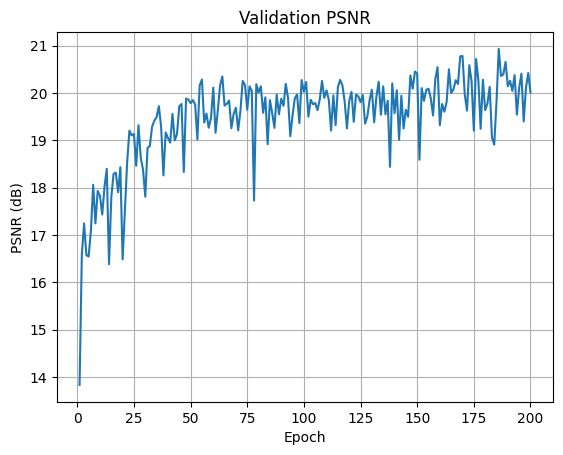

In [ ]:
# Validation PSNR
plt.plot(epochs, val_psnr)
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.title('Validation PSNR')
plt.grid(True)




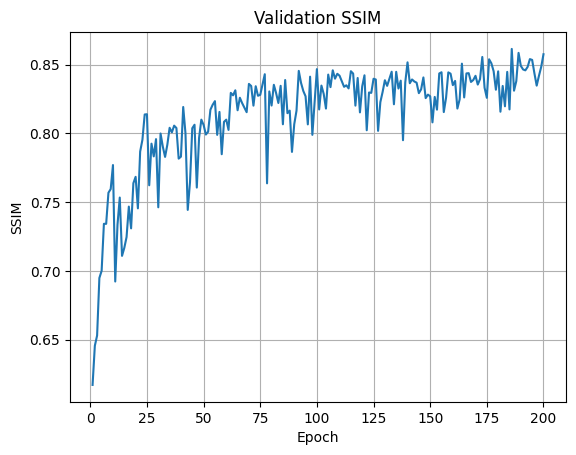

In [ ]:
# Validation SSIM

plt.plot(epochs, val_ssim)
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('Validation SSIM')
plt.grid(True)

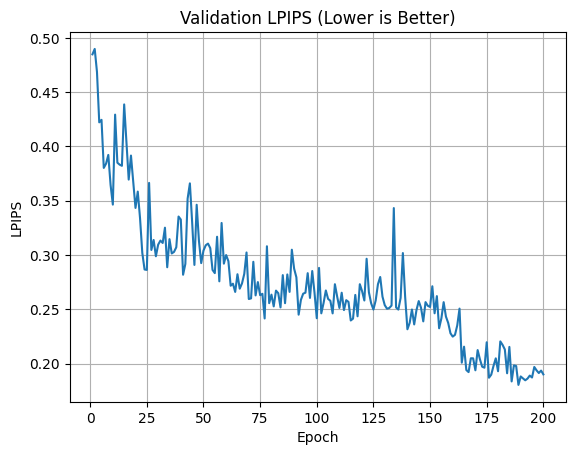

In [ ]:
# Validation LPIPS
plt.plot(epochs, val_lpips)
plt.xlabel('Epoch')
plt.ylabel('LPIPS')
plt.title('Validation LPIPS (Lower is Better)')
plt.grid(True)

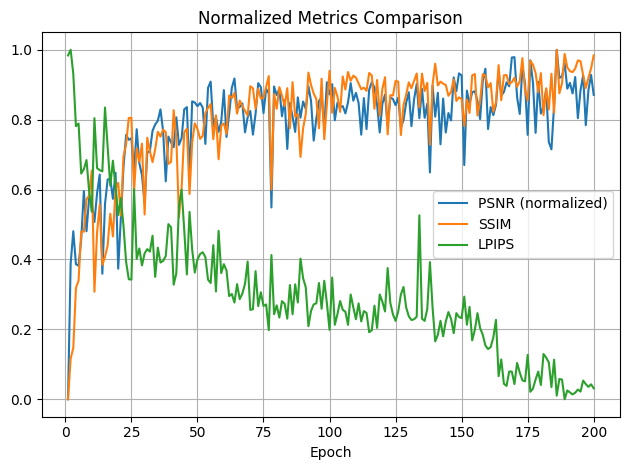

In [ ]:
# Combined Metrics
val_psnr_norm = (np.array(val_psnr)-np.min(val_psnr))/(np.max(val_psnr)-np.min(val_psnr))
val_ssim_norm = (np.array(val_ssim)-np.min(val_ssim))/(np.max(val_ssim)-np.min(val_ssim))
val_lpips_norm = (np.array(val_lpips)-np.min(val_lpips))/(np.max(val_lpips)-np.min(val_lpips))

plt.plot(epochs, val_psnr_norm, label='PSNR (normalized)')
plt.plot(epochs, val_ssim_norm, label='SSIM')
plt.plot(epochs, val_lpips_norm, label='LPIPS')
plt.xlabel('Epoch')
plt.title('Normalized Metrics Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

### TESTING ON REAL WORLD IMAGES (CAPTURED BY US)

In [15]:
generator = Generator().to(device)
# Load model with explicit CPU mapping
generator.load_state_dict(torch.load("best_model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [21]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Set device (automatically handles CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Image transformations
transform = transforms.Compose([
    transforms.Resize((225, 225)),
    transforms.ToTensor()
])

# Create file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    clear_output(wait=True)
    display(upload_widget)

    # Load model with proper device mapping
    generator = Generator().to(device)
    state_dict = torch.load("epoch_186.pth", map_location=device)
    generator.load_state_dict(state_dict['generator'], strict=False)
    #generator.load_state_dict(state_dict) use this for best model.pth

    # Process uploaded image - NEW WAY to handle file upload
    if not upload_widget.value:
        return

    for filename, file_info in upload_widget.value.items():
        image_bytes = file_info['content']
        pil_image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

        # Transform and process
        input_tensor = transform(pil_image).unsqueeze(0).to(device)

        generator.eval()
        with torch.no_grad():
            enhanced_tensor = generator(input_tensor)

        enhanced_tensor = torch.clamp(enhanced_tensor, 0, 1).cpu().squeeze(0)
        enhanced_image = transforms.ToPILImage()(enhanced_tensor)

        # Display results
        plt.figure(figsize=(10,5))
        plt.subplot(1,2,1)
        plt.imshow(pil_image)
        plt.title("Original Low-Light")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(enhanced_image)
        plt.title("Enhanced High-Light")
        plt.axis("off")

        plt.show()



FileUpload(value={'rf-24mm-f1.jpg': {'metadata': {'name': 'rf-24mm-f1.jpg', 'type': 'image/jpeg', 'size': 4338…

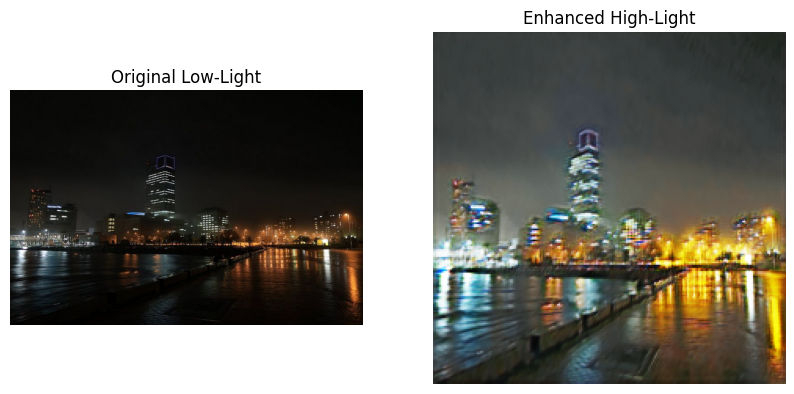

In [22]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value={'test_10.jpg': {'metadata': {'name': 'test_10.jpg', 'type': 'image/jpeg', 'size': 86224, 'la…

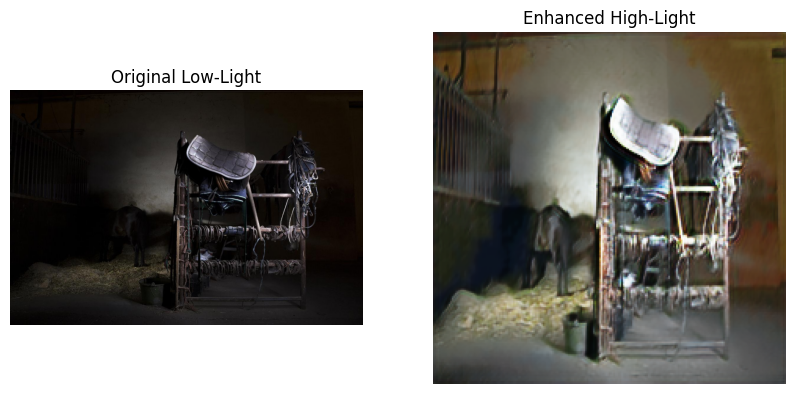

In [23]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value={'test_8.jpg': {'metadata': {'name': 'test_8.jpg', 'type': 'image/jpeg', 'size': 109269, 'las…

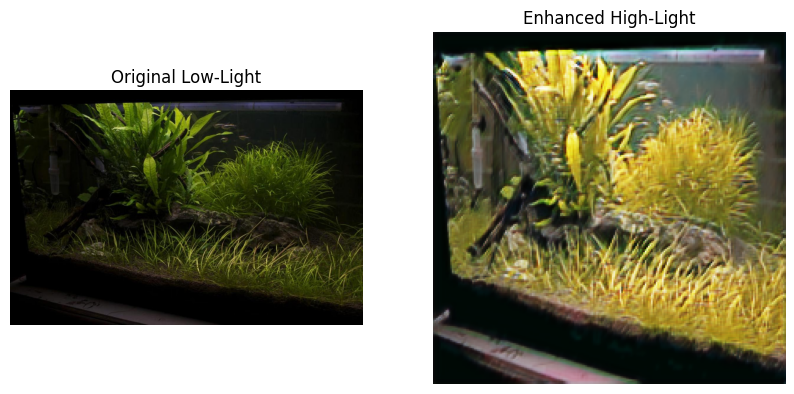

In [24]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value={'test_3.jpg': {'metadata': {'name': 'test_3.jpg', 'type': 'image/jpeg', 'size': 30972, 'last…

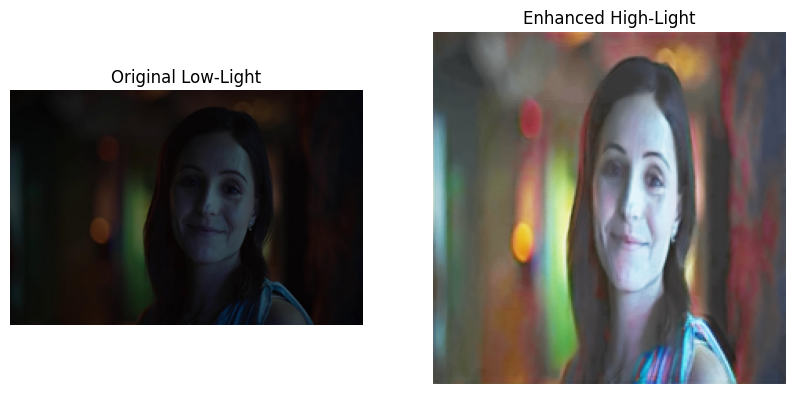

In [25]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')

FileUpload(value={'test_2.jpg': {'metadata': {'name': 'test_2.jpg', 'type': 'image/jpeg', 'size': 61333, 'last…

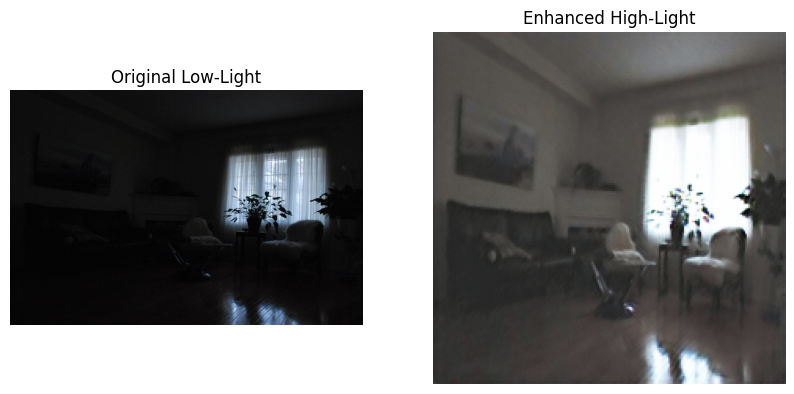

In [27]:
# Display and observe
display(upload_widget)
upload_widget.observe(on_upload_change, names='value')